## Importing libraries/data

### Importing Libraries

In [1]:
# For general use
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# For our classifiers
from sklearn import neighbors
from sklearn import naive_bayes
from sklearn import tree
from sklearn import neural_network
from sklearn import preprocessing

# For confusion matrix/data importing
from sklearn import metrics  
from sklearn.datasets import load_digits  

### Importing CSV data

In [2]:
file = "../../Data/CSV/"

print("Getting digits")
dfs_digi = []
for cls in ['0','1','2','3','4','5','6','7','8','9']:
    print(f"Loading {cls}.CSV...")
    a = pd.read_csv(file+cls+".csv", index_col=0)
    a['class'] = cls
    dfs_digi.append(a)
    
print("\nGetting math symbols")
dfs_math = []
for cls in ['+', ')', '(', ',', '-']:
    print(f"Loading {cls}.CSV...")
    a = pd.read_csv(file+cls+".csv", index_col=0)
    a['class'] = cls
    dfs_math.append(a)

print("Concatenating Data...")
df_math = pd.concat(dfs_math,ignore_index=True, sort=False)
df_digi = pd.concat(dfs_digi,ignore_index=True, sort=False)
print("Done")

Getting digits
Loading 0.CSV...
Loading 1.CSV...
Loading 2.CSV...
Loading 3.CSV...
Loading 4.CSV...
Loading 5.CSV...
Loading 6.CSV...
Loading 7.CSV...
Loading 8.CSV...
Loading 9.CSV...

Getting math symbols
Loading +.CSV...
Loading ).CSV...
Loading (.CSV...
Loading ,.CSV...
Loading -.CSV...
Concatenating Data...
Done


### Test/Train split

In [3]:
Dfeatures = [feature for feature in df_digi]
Dfeatures.remove("class")

Dtrain_X = np.array(df_digi[df_digi.index%2 == 0][Dfeatures])
Dtrain_y = df_digi[df_digi.index%2 == 0]["class"]
Dtest_X = np.array(df_digi[df_digi.index%2 == 1][Dfeatures])
Dtest_y = df_digi[df_digi.index%2 == 1]["class"]

Mfeatures = [feature for feature in df_math]
Mfeatures.remove("class")

Mtrain_X = np.array(df_math[df_math.index%2 == 0][Mfeatures])
Mtrain_y = df_math[df_math.index%2 == 0]["class"]
Mtest_X = np.array(df_math[df_math.index%2 == 1][Mfeatures])
Mtest_y = df_math[df_math.index%2 == 1]["class"]


## Testing classifiers
I conducted some "accuracy vs parameter" tests and found these to the be the optimal `n_neighbors` and `max_depth` values. In the future I will put those tests here

In [4]:
# Kneighbors
clf = neighbors.KNeighborsClassifier(n_neighbors=1)
print("Fitting...")
clf.fit(Dtrain_X, Dtrain_y)
print("Scoring...")
print("Digit score: ", clf.score(Dtest_X[:100], Dtest_y[:100]), "\n")

print("Fitting...")
clf.fit(Mtrain_X, Mtrain_y)
print("Scoring...")
print("Math score: ", clf.score(Mtest_X[:100], Mtest_y[:100]), "\n")


Fitting...
Scoring...
Digit score:  1.0 

Fitting...
Scoring...
Math score:  0.36 



In [5]:
# Decision Tree
clf = tree.DecisionTreeClassifier(random_state=10)

print("Fitting...")
clf.fit(Dtrain_X, Dtrain_y)
print("Scoring...")
print("Digit score: ", clf.score(Dtest_X[:100], Dtest_y[:100]), "\n")

print("Fitting...")
clf.fit(Mtrain_X, Mtrain_y)
print("Scoring...")
print("Math score: ", clf.score(Mtest_X[:100], Mtest_y[:100]), "\n")

Fitting...
Scoring...
Digit score:  0.9 

Fitting...
Scoring...
Math score:  0.74 



In [6]:
# Gaussian Naive Bayes
clf = naive_bayes.GaussianNB()

print("Fitting...")
clf.fit(Dtrain_X, Dtrain_y)
print("Scoring...")
print("Digit score: ", clf.score(Dtest_X, Dtest_y), "\n")

print("Fitting...")
clf.fit(Mtrain_X, Mtrain_y)
print("Scoring...")
print("Math score: ", clf.score(Mtest_X, Mtest_y), "\n")

Fitting...
Scoring...
Digit score:  0.582791185729276 

Fitting...
Scoring...
Math score:  0.9034627492130115 



### Finding most accurate hidden_layer_sizes value

In [7]:
# Using a small subset of data for faster results
data_portion = 500
Dtrain_X2 = np.array(df_digi[df_digi.index%data_portion == 0][Dfeatures])
Dtrain_y2 = df_digi[df_digi.index%data_portion == 0]["class"]
Dtest_X2 = np.array(df_digi[df_digi.index%data_portion == 1][Dfeatures])
Dtest_y2 = df_digi[df_digi.index%data_portion == 1]["class"]

Mtrain_X2 = np.array(df_math[df_math.index%data_portion == 0][Mfeatures])
Mtrain_y2 = df_math[df_math.index%data_portion == 0]["class"]
Mtest_X2 = np.array(df_math[df_math.index%data_portion == 1][Mfeatures])
Mtest_y2 = df_math[df_math.index%data_portion == 1]["class"]

sc = preprocessing.StandardScaler()
Dtrain_X2 = sc.fit_transform(Dtrain_X2)
Dtest_X2 = sc.fit_transform(Dtest_X2)
Mtrain_X2 = sc.fit_transform(Mtrain_X2)
Mtest_X2 = sc.fit_transform(Mtest_X2)

In [8]:
max(Mtest_X2[0])

4.358898943540674

In [9]:
# Recording scores
Dscores = []
Mscores = []
MAX = 45
for hid in range(1, MAX):
    print(f"fitting and scoring hidden_layer_sizes={hid}...")
    clf = neural_network.MLPClassifier(hidden_layer_sizes=(hid),max_iter=3000, random_state=42)
    
    clf.fit(Dtrain_X2, Dtrain_y2)
    Dscores.append(clf.score(Dtest_X2, Dtest_y2))
    
    clf.fit(Mtrain_X2, Mtrain_y2)
    Mscores.append(clf.score(Mtest_X2, Mtest_y2))

fitting and scoring hidden_layer_sizes=1...
fitting and scoring hidden_layer_sizes=2...
fitting and scoring hidden_layer_sizes=3...
fitting and scoring hidden_layer_sizes=4...
fitting and scoring hidden_layer_sizes=5...
fitting and scoring hidden_layer_sizes=6...
fitting and scoring hidden_layer_sizes=7...
fitting and scoring hidden_layer_sizes=8...
fitting and scoring hidden_layer_sizes=9...
fitting and scoring hidden_layer_sizes=10...
fitting and scoring hidden_layer_sizes=11...
fitting and scoring hidden_layer_sizes=12...
fitting and scoring hidden_layer_sizes=13...
fitting and scoring hidden_layer_sizes=14...
fitting and scoring hidden_layer_sizes=15...
fitting and scoring hidden_layer_sizes=16...
fitting and scoring hidden_layer_sizes=17...
fitting and scoring hidden_layer_sizes=18...
fitting and scoring hidden_layer_sizes=19...
fitting and scoring hidden_layer_sizes=20...
fitting and scoring hidden_layer_sizes=21...
fitting and scoring hidden_layer_sizes=22...
fitting and scoring

In [10]:
for i, Dscore, Mscore in zip(range(MAX), Dscores, Mscores):
    print("hidden_layer_sizes =", i+10, '  ::  ', Mscore, ' :: ', Dscore )

hidden_layer_sizes = 10   ::   0.25  ::  0.1282051282051282
hidden_layer_sizes = 11   ::   0.35  ::  0.2564102564102564
hidden_layer_sizes = 12   ::   0.3  ::  0.20512820512820512
hidden_layer_sizes = 13   ::   0.3  ::  0.48717948717948717
hidden_layer_sizes = 14   ::   0.5  ::  0.3333333333333333
hidden_layer_sizes = 15   ::   0.6  ::  0.5128205128205128
hidden_layer_sizes = 16   ::   0.55  ::  0.4358974358974359
hidden_layer_sizes = 17   ::   0.5  ::  0.5128205128205128
hidden_layer_sizes = 18   ::   0.5  ::  0.46153846153846156
hidden_layer_sizes = 19   ::   0.55  ::  0.5128205128205128
hidden_layer_sizes = 20   ::   0.5  ::  0.5641025641025641
hidden_layer_sizes = 21   ::   0.5  ::  0.4358974358974359
hidden_layer_sizes = 22   ::   0.6  ::  0.46153846153846156
hidden_layer_sizes = 23   ::   0.6  ::  0.6410256410256411
hidden_layer_sizes = 24   ::   0.4  ::  0.48717948717948717
hidden_layer_sizes = 25   ::   0.5  ::  0.5128205128205128
hidden_layer_sizes = 26   ::   0.6  ::  0.51282

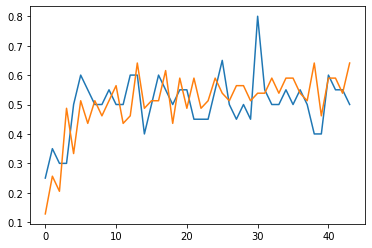

In [11]:
plt.plot(Mscores)
plt.plot(Dscores)
plt.show()

In [12]:
for i, Dscore, Mscore in zip(range(MAX), Dscores, Mscores):
    print("hidden_layer_sizes =", i+1, '  ::  ', Mscore, ' :: ', Dscore )

hidden_layer_sizes = 1   ::   0.25  ::  0.1282051282051282
hidden_layer_sizes = 2   ::   0.35  ::  0.2564102564102564
hidden_layer_sizes = 3   ::   0.3  ::  0.20512820512820512
hidden_layer_sizes = 4   ::   0.3  ::  0.48717948717948717
hidden_layer_sizes = 5   ::   0.5  ::  0.3333333333333333
hidden_layer_sizes = 6   ::   0.6  ::  0.5128205128205128
hidden_layer_sizes = 7   ::   0.55  ::  0.4358974358974359
hidden_layer_sizes = 8   ::   0.5  ::  0.5128205128205128
hidden_layer_sizes = 9   ::   0.5  ::  0.46153846153846156
hidden_layer_sizes = 10   ::   0.55  ::  0.5128205128205128
hidden_layer_sizes = 11   ::   0.5  ::  0.5641025641025641
hidden_layer_sizes = 12   ::   0.5  ::  0.4358974358974359
hidden_layer_sizes = 13   ::   0.6  ::  0.46153846153846156
hidden_layer_sizes = 14   ::   0.6  ::  0.6410256410256411
hidden_layer_sizes = 15   ::   0.4  ::  0.48717948717948717
hidden_layer_sizes = 16   ::   0.5  ::  0.5128205128205128
hidden_layer_sizes = 17   ::   0.6  ::  0.51282051282051

Clearly `hidden_layer_sizes=16` is the most accurate value.

Using this value, I will conduct accuracy testing with all of the data

In [13]:
data_portion = 19
Dtrain_X3 = np.array(df_digi[df_digi.index%data_portion != 0][Dfeatures])
Dtrain_y3 = df_digi[df_digi.index%data_portion != 0]["class"]
Dtest_X3 = np.array(df_digi[df_digi.index%data_portion == 0][Dfeatures])
Dtest_y3 = df_digi[df_digi.index%data_portion == 0]["class"]

Mtrain_X3 = np.array(df_math[df_math.index%data_portion != 0][Mfeatures])
Mtrain_y3 = df_math[df_math.index%data_portion != 0]["class"]
Mtest_X3 = np.array(df_math[df_math.index%data_portion == 0][Mfeatures])
Mtest_y3 = df_math[df_math.index%data_portion == 0]["class"]

sc = preprocessing.StandardScaler()
Dtrain_X3 = sc.fit_transform(Dtrain_X3)
Dtest_X3 = sc.fit_transform(Dtest_X3)
Mtrain_X3 = sc.fit_transform(Mtrain_X3)
Mtest_X3 = sc.fit_transform(Mtest_X3)


In [14]:
clf_digi = neural_network.MLPClassifier(hidden_layer_sizes=(39),max_iter=8000, random_state=42)
print("fitting...")
clf_digi.fit(Dtrain_X3, Dtrain_y3)
print("scoring...")
print("Digits scored:", clf_digi.score(Dtest_X3, Dtest_y3))

clf_math = neural_network.MLPClassifier(hidden_layer_sizes=(39),max_iter=8000, random_state=42)
print("fitting...")
clf_math.fit(Mtrain_X3, Mtrain_y3)
print("scoring...")
print("Math scored:", clf_math.score(Mtest_X3, Mtest_y3))

fitting...
scoring...
Digits scored: 0.9412350597609562
fitting...
scoring...
Math scored: 0.9860557768924303


In [15]:
import pickle
with open('clf_digi.pk', 'wb') as fout:
    pickle.dump(clf_digi, fout)
with open('clf_math.pk', 'wb') as fout:
    pickle.dump(clf_math, fout)

In [16]:
clf_digi2 = 10
clf_math2 = 10
with open('clf_digi.pk', 'rb') as fin:
    clf_digi2 = pickle.load(fin)
with open('clf_math.pk', 'rb') as fin:
    clf_math2 = pickle.load(fin)
    
print(clf_digi2.score(Dtest_X3, Dtest_y3))
print(clf_math2.score(Mtest_X3, Mtest_y3))

0.9412350597609562
0.9860557768924303
